In [155]:
import itertools
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

from download_wb_data import download_wb_data, download_cat_info
from lib_gather_data import get_country_name_dicts, df_to_iso3
from wb_api_wrapper import *

import warnings
warnings.filterwarnings("ignore")

In [156]:
root_dir = "./"
any_to_wb, iso3_to_wb, iso2_iso3 = get_country_name_dicts(root_dir)

loading file country_name_mappings/any_name_to_wb_name.csv from inputs
loading file country_name_mappings/iso3_to_wb_name.csv from inputs
loading file country_name_mappings/names_to_iso.csv from inputs


In [260]:
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 100)

# Data Gathering

In [158]:
gdp_pc = get_wb_series('NY.GDP.PCAP.PP.KD', 'gdp_pc').dropna().astype(float).to_frame().reset_index()
gdp_pc = gdp_pc.loc[gdp_pc.groupby('country').year.idxmax()].drop('year', axis=1)
gdp_pc = df_to_iso3(gdp_pc, 'country', any_to_wb).dropna(subset='iso3').set_index('iso3', drop=True).drop('country', axis=1)
print(gdp_pc)

            gdp_pc
iso3              
AFG    1516.273265
ALB   15492.067404
DZA   11198.233483
AGO    5906.115677
ATG   22321.870019
...            ...
VUT    2785.903860
VNM   11396.531305
PSE    5722.409175
ZMB    3365.873780
ZWE    2207.957033

[194 rows x 1 columns]


array([[<Axes: title={'center': 'gdp_pc'}>]], dtype=object)

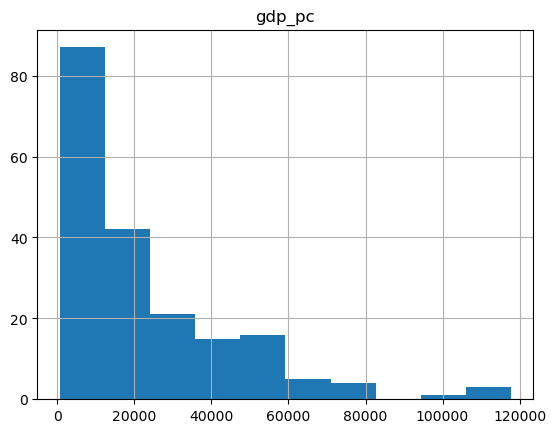

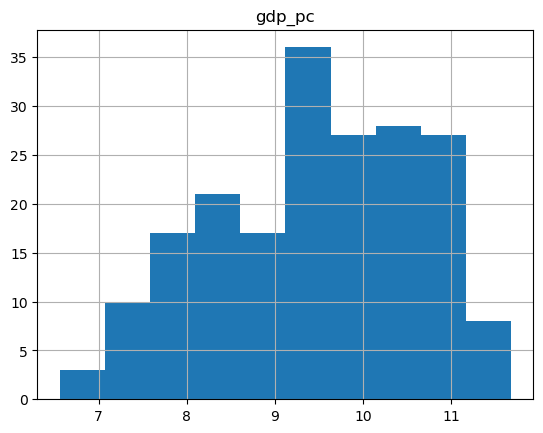

In [159]:
gdp_pc.hist()
(np.log(gdp_pc)).hist()

In [160]:
gvt_effectiveness = get_wb_series('GE.EST', 'GE_EST').dropna().astype(float).to_frame().reset_index()
gvt_effectiveness = gvt_effectiveness.loc[gvt_effectiveness.groupby('country').year.idxmax()].drop('year', axis=1)
gvt_effectiveness = df_to_iso3(gvt_effectiveness, 'country', any_to_wb).set_index('iso3', drop=True).drop('country', axis=1)
print(gvt_effectiveness)

        GE_EST
iso3          
AFG  -1.879552
ALB   0.065063
DZA  -0.513090
ASM   0.667918
AND   1.495305
...        ...
VIR   0.667918
PSE  -0.900953
YEM  -2.232542
ZMB  -0.658233
ZWE  -1.254613

[205 rows x 1 columns]


array([[<Axes: title={'center': 'GE_EST'}>]], dtype=object)

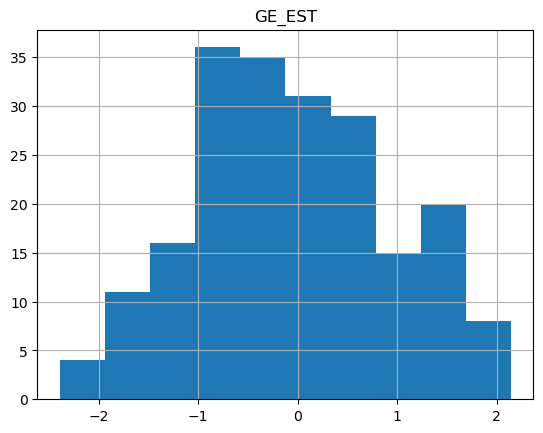

In [161]:
gvt_effectiveness.hist()

In [162]:
remittances = get_wb_series('BX.TRF.PWKR.DT.GD.ZS', 'remittances_gdp').dropna().astype(float).to_frame().reset_index()
remittances = remittances.loc[remittances.groupby('country').year.idxmax()].drop('year', axis=1)
remittances = df_to_iso3(remittances, 'country', any_to_wb).dropna(subset='iso3').set_index('iso3', drop=True).drop('country', axis=1)
print(remittances)

      remittances_gdp
iso3                 
AFG          2.102828
ALB          9.226106
DZA          0.902738
AND          1.593959
AGO          0.013116
...               ...
VNM          3.216862
PSE         21.186165
YEM         17.209770
ZMB          0.834892
ZWE         11.273013

[196 rows x 1 columns]


array([[<Axes: title={'center': 'remittances_gdp'}>]], dtype=object)

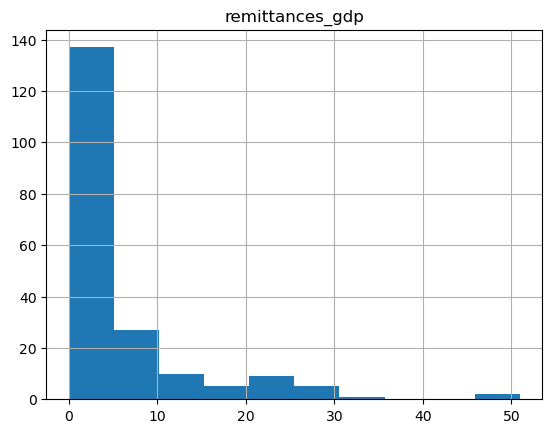

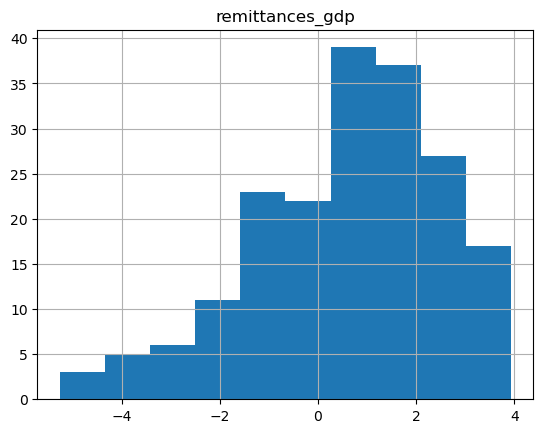

In [163]:
remittances.hist()
np.log(remittances[remittances > 0]).hist()

In [164]:
social_prot_expenditure = pd.read_excel("./inputs/social_share_regression/ILO/tableA4.3_data.xlsx", index_col=0)
social_prot_expenditure = social_prot_expenditure["Total expenditure on social protection (excluding health)"]
social_prot_expenditure.rename('ILO_social', inplace=True)
social_prot_expenditure = social_prot_expenditure.replace('...', np.nan).dropna()
social_prot_expenditure = social_prot_expenditure.astype(float)
social_prot_expenditure /= 100
social_prot_expenditure = df_to_iso3(social_prot_expenditure.reset_index(), 'country', any_to_wb).set_index('iso3').drop('country', axis=1)
print(social_prot_expenditure)

      ILO_social
iso3            
DZA        0.089
EGY        0.095
LBY        0.044
MAR        0.045
SDN        0.007
...          ...
SVN        0.167
ESP        0.168
SWE        0.195
CHE        0.128
GBR        0.151

[185 rows x 1 columns]


array([[<Axes: title={'center': 'ILO_social'}>]], dtype=object)

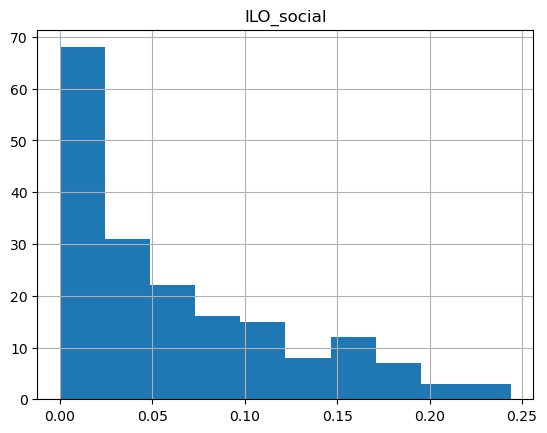

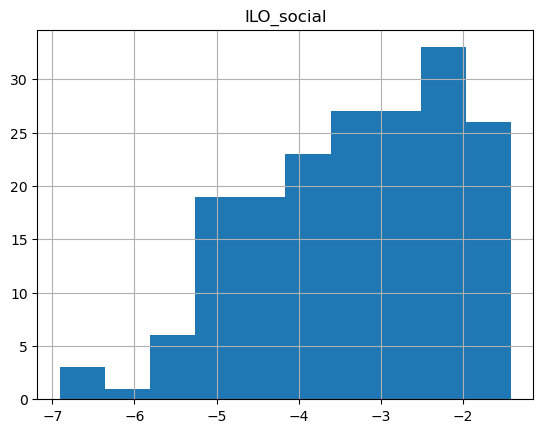

In [165]:
social_prot_expenditure.hist()
np.log(social_prot_expenditure[social_prot_expenditure > 0]).hist()

In [166]:
pension_coverage = pd.read_excel("./inputs/social_share_regression/ILO/wcms_tableA4.2.xlsx", na_values='…').iloc[29:, [2, 15]]
pension_coverage.columns = ['iso3', 'pension_coverage']
pension_coverage.set_index('iso3', inplace=True)
pension_coverage.dropna(inplace=True)
pension_coverage = pension_coverage.astype(float) / 100

array([[<Axes: title={'center': 'pension_coverage'}>]], dtype=object)

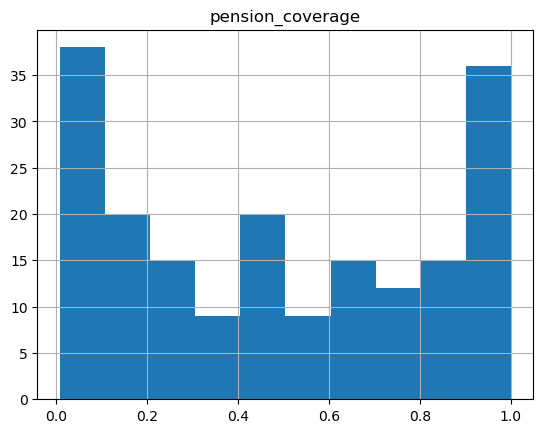

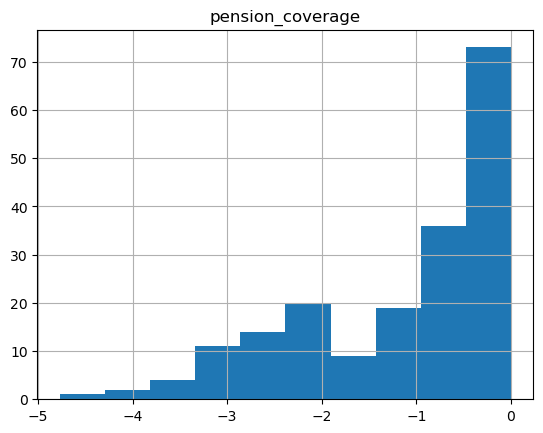

In [167]:
pension_coverage.hist()
np.log(pension_coverage[pension_coverage > 0]).hist()

In [168]:
wb_country_classification = pd.read_excel("./inputs/WB_country_classification/country_classification.xlsx")[['Economy', 'Region', 'Income group']]
wb_country_classification.rename(columns={'Economy': 'country', 'Region': 'region', 'Income group': 'income_group'}, inplace=True)
wb_country_classification.set_index('country', inplace=True)
wb_country_classification.loc['Venezuela, RB', 'income_group'] = 'Upper middle income'
wb_country_classification.dropna(inplace=True)
wb_country_classification = df_to_iso3(wb_country_classification.reset_index(), 'country', any_to_wb).dropna().set_index('iso3').drop('country', axis=1)
for r in wb_country_classification['region'].unique():
    wb_country_classification[r.replace('&', '').replace('  ', ' ').replace(' ', '_').replace('-', '_')] = wb_country_classification['region'] == r
for ig in wb_country_classification['income_group'].unique():
    wb_country_classification[ig.replace(' ', '_')] = wb_country_classification['income_group'] == ig
print(wb_country_classification)

                          region         income_group  Latin_America_Caribbean  South_Asia  Sub_Saharan_Africa  Europe_Central_Asia  \
iso3                                                                                                                                  
ABW    Latin America & Caribbean          High income                     True       False               False                False   
AFG                   South Asia           Low income                    False        True               False                False   
AGO           Sub-Saharan Africa  Lower middle income                    False       False                True                False   
ALB        Europe & Central Asia  Upper middle income                    False       False               False                 True   
AND        Europe & Central Asia          High income                    False       False               False                 True   
...                          ...                  ...  

In [169]:
gini_index = get_wb_series('SI.POV.GINI', 'gini_index').dropna().astype(float).to_frame().reset_index()
gini_index = gini_index.loc[gini_index.groupby('country').year.idxmax()].drop('year', axis=1)
gini_index = df_to_iso3(gini_index, 'country', any_to_wb).dropna(subset='iso3').set_index('iso3', drop=True).drop('country', axis=1)
print(gini_index)

      gini_index
iso3            
ALB         29.4
DZA         27.6
AGO         51.3
ARG         42.0
ARM         27.9
...          ...
VNM         36.8
PSE         33.7
YEM         36.7
ZMB         55.9
ZWE         50.3

[162 rows x 1 columns]


array([[<Axes: title={'center': 'gini_index'}>]], dtype=object)

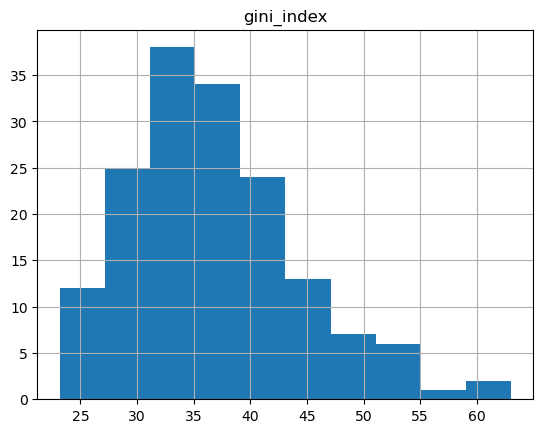

In [170]:
gini_index.hist()

In [171]:
fsc = [
    'Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyzstan', 'Latvia', 
    'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine','Uzbekistan'
]
former_yugoslavia = [
    'Bosnia and Herzegovina', 'Croatia', 'Kosovo', 'Montenegro', 'North Macedonia', 'Serbia', 
    'Slovenia'
]
former_socialist_countries = fsc + former_yugoslavia + [
    'Albania', 'Bulgaria', 'Czech Republic', 'Hungary', 'Poland', 'Romania', 'Slovakia'
]

fsr_old = [
    'Albania', 'Armenia', 'Azerbaijan', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Estonia',
    'Georgia', 'Hungary', 'Kazakhstan', 'Kosovo', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'North Macedonia', 'Moldova',
    'Montenegro', 'Poland', 'Romania', 'Russian Federation', 'Serbia', 'Slovak Republic', 'Slovenia', 'Tajikistan',
    'Turkmenistan', 'Uzbekistan'
]

fsc = pd.DataFrame(
    index=pd.Index(former_socialist_countries, name='country'),
    data=True,
    columns=['FSR']
)
fsc = df_to_iso3(fsc.reset_index(), 'country', any_to_wb).set_index('iso3').drop('country', axis=1)
print(fsc)

       FSR
iso3      
ARM   True
AZE   True
BLR   True
EST   True
GEO   True
KAZ   True
KGZ   True
LVA   True
LTU   True
MDA   True
RUS   True
TJK   True
TKM   True
UKR   True
UZB   True
BIH   True
HRV   True
XKX   True
MNE   True
MKD   True
SRB   True
SVN   True
ALB   True
BGR   True
CZE   True
HUN   True
POL   True
ROU   True
SVK   True


        GE_EST  remittances_gdp  ILO_social                      region         income_group Latin_America_Caribbean South_Asia Sub_Saharan_Africa  \
iso3                                                                                                                                                 
AFG  -1.879552         2.102828       0.018                  South Asia           Low income                   False       True              False   
ALB   0.065063         9.226106       0.092       Europe & Central Asia  Upper middle income                   False      False              False   
DZA  -0.513090         0.902738       0.089  Middle East & North Africa  Lower middle income                   False      False              False   
ASM   0.667918              NaN         NaN         East Asia & Pacific          High income                   False      False              False   
AND   1.495305         1.593959       0.011       Europe & Central Asia          High income        

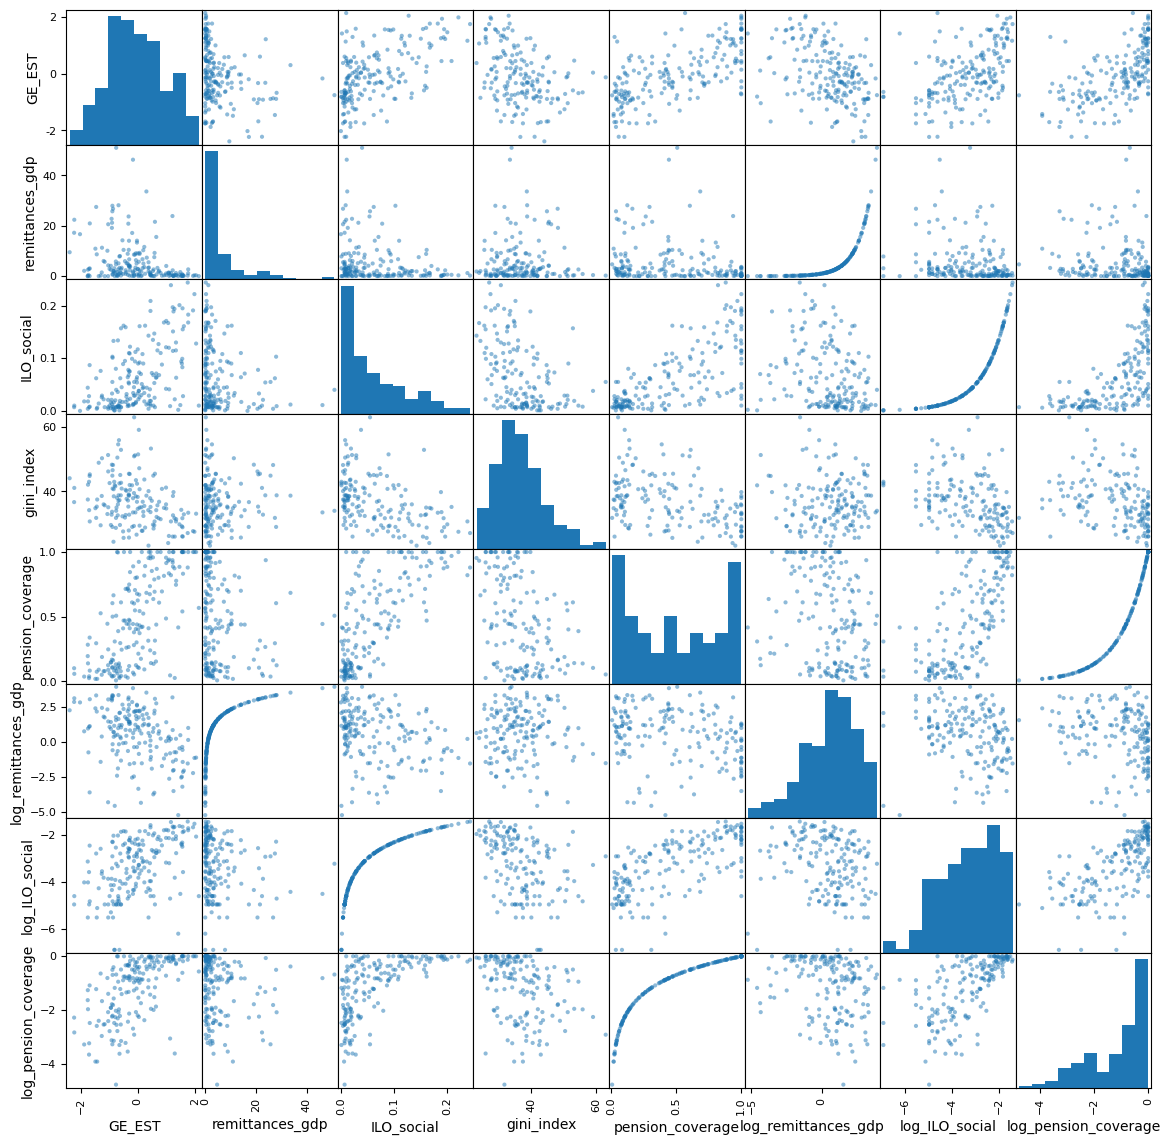

In [172]:
# X = pd.concat([gdp_pc, gvt_effectiveness, remittances, social_prot_expenditure, wb_country_classification, gini_index], axis=1).dropna()
X = pd.concat([gvt_effectiveness, remittances, social_prot_expenditure, wb_country_classification, gini_index, pension_coverage], axis=1)
X = pd.concat([X, fsc], axis=1)
X['FSR'] = X['FSR'].fillna(False).astype(int)
# X.dropna(inplace=True)
categorial_columns = list(wb_country_classification.columns) + ['FSR']
print(X)
X['log_remittances_gdp'] = np.log(X['remittances_gdp'])
X['log_ILO_social'] = np.log(X['ILO_social'])
X['log_pension_coverage'] = np.log(X['pension_coverage'])
X = X.replace({np.inf: np.nan, -np.inf: np.nan})
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
pd.plotting.scatter_matrix(X.drop(categorial_columns, axis=1), ax=ax)
print("\n\n###################\nCorrelation\n###################\n", X.drop(categorial_columns, axis=1).corr())

In [173]:
_, Y_social = download_wb_data(root_dir=root_dir, include_remitances=True, use_additional_data=False, drop_incomplete=False)
Y_social = Y_social.drop('axfin', axis=1)

loading file country_name_mappings/any_name_to_wb_name.csv from inputs
loading file country_name_mappings/iso3_to_wb_name.csv from inputs
loading file country_name_mappings/names_to_iso.csv from inputs
82 countries were not found in the world map. They will be excluded from the plot.
96 countries were not found in the world map. They will be excluded from the plot.
94 countries were not found in the world map. They will be excluded from the plot.
16 countries were not found in the world map. They will be excluded from the plot.
24 countries were not found in the world map. They will be excluded from the plot.
23 countries were not found in the world map. They will be excluded from the plot.
24 countries were not found in the world map. They will be excluded from the plot.
23 countries were not found in the world map. They will be excluded from the plot.
21 countries were not found in the world map. They will be excluded from the plot.
loading file FINDEX/findex_axfin.csv from inputs
7 

In [174]:
bottom_40 = Y_social.drop(['q3', 'q4', 'q5'], level='income_cat').dropna()
bottom_40 = bottom_40[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / bottom_40.income_share.groupby('iso3').sum()
bottom_40.rename('social_bottom40', inplace=True)
top_60 = Y_social.drop(['q1', 'q2'], level='income_cat').dropna()
top_60 = top_60[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / top_60.income_share.groupby('iso3').sum()
top_60.rename('social_top60', inplace=True)
top_40 = Y_social.drop(['q1', 'q2'], level='income_cat').dropna()
top_40 = top_40[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / top_40.income_share.groupby('iso3').sum()
top_40.rename('social_top40', inplace=True)
print(bottom_40)
print(top_60)
print(top_40)

iso3
AGO    0.151075
ALB    0.212207
ARG    0.239702
ARM    0.608379
AZE    0.020374
         ...   
XKX    0.263828
YEM    0.143651
ZAF    0.783326
ZMB    0.008404
ZWE    0.091104
Name: social_bottom40, Length: 101, dtype: float64
iso3
AGO    0.142823
ALB    0.164662
ARG    0.184092
ARM    0.288714
AZE    0.015340
         ...   
XKX    0.180454
YEM    0.087953
ZAF    0.310917
ZMB    0.005696
ZWE    0.120501
Name: social_top60, Length: 101, dtype: float64
iso3
AGO    0.142823
ALB    0.164662
ARG    0.184092
ARM    0.288714
AZE    0.015340
         ...   
XKX    0.180454
YEM    0.087953
ZAF    0.310917
ZMB    0.005696
ZWE    0.120501
Name: social_top40, Length: 101, dtype: float64


In [175]:
Y_social = Y_social.unstack('income_cat')[['social']]
Y_social.columns = [f"{c[0]}_{c[1]}" for c in Y_social.columns]

In [176]:
adequacy_remittances = download_cat_info(name='adequacy_remittances', id_q1='per_pr_allpr.adq_q1_tot',
                                         id_q2='per_pr_allpr.adq_q2_tot', id_q3='per_pr_allpr.adq_q3_tot',
                                         id_q4='per_pr_allpr.adq_q4_tot', id_q5='per_pr_allpr.adq_q5_tot',
                                         most_recent_value=False, upper_bound=100, lower_bound=0) / 100
# Total transfer amount received by all beneficiaries in a population group as a share of the total welfare of
# beneficiaries in that group
adequacy_all_prot_lab = download_cat_info(name='adequacy_all_prot_lab', id_q1='per_allsp.adq_q1_tot',
                                          id_q2='per_allsp.adq_q2_tot', id_q3='per_allsp.adq_q3_tot',
                                          id_q4='per_allsp.adq_q4_tot', id_q5='per_allsp.adq_q5_tot',
                                          most_recent_value=False, upper_bound=100, lower_bound=0) / 100
# Coverage
coverage_remittances = download_cat_info(name='coverage_remittances', id_q1='per_pr_allpr.cov_q1_tot',
                                         id_q2='per_pr_allpr.cov_q2_tot', id_q3='per_pr_allpr.cov_q3_tot',
                                         id_q4='per_pr_allpr.cov_q4_tot', id_q5='per_pr_allpr.cov_q5_tot',
                                         most_recent_value=False, upper_bound=100, lower_bound=0) / 100
coverage_all_prot_lab = download_cat_info(name='coverage_all_prot_lab', id_q1='per_allsp.cov_q1_tot',
                                          id_q2='per_allsp.cov_q2_tot', id_q3='per_allsp.cov_q3_tot',
                                          id_q4='per_allsp.cov_q4_tot', id_q5='per_allsp.cov_q5_tot',
                                          most_recent_value=False, upper_bound=100, lower_bound=0) / 100
Y_aspire_raw = pd.concat([adequacy_remittances, adequacy_all_prot_lab, coverage_remittances, coverage_all_prot_lab], axis=1).dropna().reset_index()
Y_aspire_raw = df_to_iso3(Y_aspire_raw, 'country', any_to_wb).dropna(subset='iso3').drop('country', axis=1)
Y_aspire_raw = Y_aspire_raw.loc[Y_aspire_raw.groupby(['iso3', 'income_cat']).year.idxmax()].set_index(['iso3', 'income_cat']).drop('year', axis=1)
Y_aspire_raw = Y_aspire_raw.unstack('income_cat')
Y_aspire_raw.columns = [f"{c[0]}_{c[1]}" for c in Y_aspire_raw.columns]

In [177]:
Y = pd.concat([Y_social, bottom_40, top_60, top_40, Y_aspire_raw], axis=1).dropna(how='all')
print(Y)

      social_q1  social_q2  social_q3  social_q4  social_q5  social_bottom40  social_top60  social_top40  adequacy_remittances_q1  \
iso3                                                                                                                                
AFG    0.111074   0.082602   0.073095   0.047391   0.029296              NaN           NaN           NaN                 0.405225   
ALB    0.243888   0.192046   0.178422   0.182160   0.147807         0.212207      0.164662      0.164662                 0.160785   
AGO    0.126905   0.163002   0.134731   0.155588   0.139974         0.151075      0.142823      0.142823                 0.379655   
ARG    0.302076   0.207570   0.189000   0.188540   0.180409         0.239702      0.184092      0.184092                 0.231837   
ARM    0.750543   0.511542   0.444049   0.363883   0.173967         0.608379      0.288714      0.288714                 0.642505   
...         ...        ...        ...        ...        ...          

In [178]:
regression_data = pd.concat([X, Y], axis=1).loc[Y.index]
print(regression_data)

        GE_EST  remittances_gdp  ILO_social                      region         income_group Latin_America_Caribbean South_Asia Sub_Saharan_Africa  \
iso3                                                                                                                                                 
AFG  -1.879552         2.102828       0.018                  South Asia           Low income                   False       True              False   
ALB   0.065063         9.226106       0.092       Europe & Central Asia  Upper middle income                   False      False              False   
AGO  -1.040429         0.013116       0.021          Sub-Saharan Africa  Lower middle income                   False      False               True   
ARG  -0.282877         0.200821       0.109   Latin America & Caribbean  Upper middle income                    True      False              False   
ARM  -0.314230        10.427740       0.068       Europe & Central Asia  Upper middle income        

# Regression 'social'

In [308]:
target_variables = Y.columns
selected_formulas = {}

In [309]:
def run_regressions(formulas_, target_variable_, verbose=True):
    regression_results = pd.DataFrame(
        columns=['R2', 'Adj. R2', 'AIC', 'BIC', 'F-statistic', 'Prob(F-statistic)'],
        index=[i + 1 for i in range(len(formulas_))]
    )
    for formula_nr, formula in enumerate(formulas_):
        if verbose:
            print(f"\n\n\n###############################\nRegression for {target_variable_}\n###############################\n")
            print(f"++++++ formula {formula_nr + 1}: {formula} ++++++")
        features = [f for f in formula.split(' ~ ')[1].split(' + ') if f not in categorial_columns]
        if len(features) > 1 and verbose:
            vif_data = pd.DataFrame(
                columns=['VIF'],
                index=features,
                data=[variance_inflation_factor(X[features].dropna().values, i) for i in range(len(features))]
            )
            print(vif_data)
        model = smf.ols(formula=formula.format(target_variable_), data=regression_data, missing='drop')
        regression = model.fit()
        if verbose:
            print(regression.summary())
        regression_results.loc[formula_nr + 1] = [regression.rsquared, regression.rsquared_adj, regression.aic, regression.bic, regression.fvalue, regression.f_pvalue]
    return regression_results

## Q1

In [310]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR',
    # '{} ~ ILO_social + GE_EST + FSR',
]
target_variable = target_variables[0]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q1
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.100614
GE_EST               1.182505
log_remittances_gdp  1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q1   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     9.326
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           2.95e-11
Time:                        17:26:23   Log-Likelihood:                 54.171
No. Observations:                  99   AIC:                            -82.34
Df Residuals:                      86   BIC:                            -48.60
Df Model:                          12            

## Q1 with pension coverage

In [311]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage',
]
target_variable = target_variables[0]
print("\n\n", run_regressions(formulas, target_variable))




###############################
Regression for social_q1
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                            OLS Regression Results                            
Dep. Variable:              social_q1   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     8.523
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           9.94e-11
Time:                        17:26:23   Log-Likelihood:                 53.910
No. Observations:                  98   AIC:                            -79.82
Df Residuals:                      84   BIC:                            -43.63


## Q2

In [312]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + Low_income + Lower_middle_income',
    '{} ~ ILO_social + remittances_gdp + FSR + Low_income + Lower_middle_income',
    # '{} ~ ILO_social + FSR + Low_income + Lower_middle_income',
]
target_variable = target_variables[1]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q2
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.100614
GE_EST               1.182505
log_remittances_gdp  1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q2   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     7.642
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           1.96e-09
Time:                        17:26:23   Log-Likelihood:                 70.485
No. Observations:                  99   AIC:                            -115.0
Df Residuals:                      86   BIC:                            -81.23
Df Model:                          12            

## Q3

In [313]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Low_income + Lower_middle_income',
]
target_variable = target_variables[2]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q3
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.100614
GE_EST               1.182505
log_remittances_gdp  1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q3   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     6.686
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           2.51e-08
Time:                        17:26:23   Log-Likelihood:                 76.579
No. Observations:                  99   AIC:                            -127.2
Df Residuals:                      86   BIC:                            -93.42
Df Model:                          12            

## Q4

In [314]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa + Low_income + Lower_middle_income',
    '{} ~ ILO_social + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Low_income + Lower_middle_income',
]
target_variable = target_variables[3]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q4
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.100614
GE_EST               1.182505
log_remittances_gdp  1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q4   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     5.554
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           6.09e-07
Time:                        17:26:23   Log-Likelihood:                 83.841
No. Observations:                  99   AIC:                            -141.7
Df Residuals:                      86   BIC:                            -107.9
Df Model:                          12            

## Q4 with pension coverage

In [315]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[3]
print("\n\n", run_regressions(formulas, target_variable))




###############################
Regression for social_q4
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                            OLS Regression Results                            
Dep. Variable:              social_q4   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     5.032
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           1.75e-06
Time:                        17:26:24   Log-Likelihood:                 82.860
No. Observations:                  98   AIC:                            -137.7
Df Residuals:                      84   BIC:                            -101.5


## Q5

In [316]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ log_ILO_social + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ log_ILO_social + log_remittances_gdp + region',
    '{} ~ log_ILO_social + log_remittances_gdp + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + Middle_East_North_Africa + Sub_Saharan_Africa',
]
target_variable = target_variables[4]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q5
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.100614
GE_EST               1.182505
log_remittances_gdp  1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q5   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     3.625
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           0.000211
Time:                        17:26:24   Log-Likelihood:                 102.96
No. Observations:                  99   AIC:                            -179.9
Df Residuals:                      86   BIC:                            -146.2
Df Model:                          12            

## Q5 with pension coverage

In [317]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage',
]
target_variable = target_variables[4]
print("\n\n", run_regressions(formulas, target_variable))




###############################
Regression for social_q5
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                            OLS Regression Results                            
Dep. Variable:              social_q5   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     3.312
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           0.000426
Time:                        17:26:24   Log-Likelihood:                 101.81
No. Observations:                  98   AIC:                            -175.6
Df Residuals:                      84   BIC:                            -139.4


## Bottom 40%

In [318]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + Low_income + Lower_middle_income',
    '{} ~ ILO_social + remittances_gdp + FSR + Low_income + Lower_middle_income',
]
target_variable = target_variables[5]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_bottom40
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.100614
GE_EST               1.182505
log_remittances_gdp  1.261266
                            OLS Regression Results                            
Dep. Variable:        social_bottom40   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     8.251
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           6.49e-10
Time:                        17:26:24   Log-Likelihood:                 62.963
No. Observations:                  94   AIC:                            -99.93
Df Residuals:                      81   BIC:                            -66.86
Df Model:                          12      

## Top 60%

In [319]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Middle_East_North_Africa + Sub_Saharan_Africa + Latin_America_Caribbean',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Middle_East_North_Africa + Latin_America_Caribbean',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Middle_East_North_Africa',
]
target_variable = target_variables[6]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_top60
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.100614
GE_EST               1.182505
log_remittances_gdp  1.261266
                            OLS Regression Results                            
Dep. Variable:           social_top60   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     5.467
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           9.97e-07
Time:                        17:26:24   Log-Likelihood:                 92.361
No. Observations:                  94   AIC:                            -158.7
Df Residuals:                      81   BIC:                            -125.7
Df Model:                          12         

## Top 40%

In [320]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + income_group + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + GE_EST + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + Middle_East_North_Africa + Sub_Saharan_Africa',
]
target_variable = target_variables[7]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_top40
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.100614
GE_EST               1.182505
log_remittances_gdp  1.261266
                            OLS Regression Results                            
Dep. Variable:           social_top40   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     5.467
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           9.97e-07
Time:                        17:26:24   Log-Likelihood:                 92.361
No. Observations:                  94   AIC:                            -158.7
Df Residuals:                      81   BIC:                            -125.7
Df Model:                          12         

In [321]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Latin_America_Caribbean + Middle_East_North_Africa',
    '{} ~ ILO_social + log_remittances_gdp + Lower_middle_income + Low_income + Middle_East_North_Africa',
]
target_variable = target_variables[7]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_top40
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                          VIF
log_ILO_social       1.100614
GE_EST               1.182505
log_remittances_gdp  1.261266
                            OLS Regression Results                            
Dep. Variable:           social_top40   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     5.467
Date:                Thu, 14 Mar 2024   Prob (F-statistic):           9.97e-07
Time:                        17:26:24   Log-Likelihood:                 92.361
No. Observations:                  94   AIC:                            -158.7
Df Residuals:                      81   BIC:                            -125.7
Df Model:                          12         

# Regression 'adequacy_remittances'

## Q1

In [322]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[8]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q1
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q1   R-squared:                       0.161
Model:                                 OLS   Adj. R-squared:                  0.032
Method:                      Least Squares   F-statistic:                     1.251
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):              0.259
Time:                             17:26:24   Log-Likelihood:                 38.987
No. Observations:                       99   AIC:                            -49.97
Df Residuals:                 

## Q2

In [323]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[9]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q2
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q2   R-squared:                       0.235
Model:                                 OLS   Adj. R-squared:                  0.120
Method:                      Least Squares   F-statistic:                     2.051
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):             0.0254
Time:                             17:26:24   Log-Likelihood:                 48.388
No. Observations:                      101   AIC:                            -68.78
Df Residuals:                 

## Q3

In [324]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[10]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q3
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q3   R-squared:                       0.265
Model:                                 OLS   Adj. R-squared:                  0.156
Method:                      Least Squares   F-statistic:                     2.438
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):            0.00724
Time:                             17:26:24   Log-Likelihood:                 50.953
No. Observations:                      102   AIC:                            -73.91
Df Residuals:                 

## Q4

In [325]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[11]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q4
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q4   R-squared:                       0.287
Model:                                 OLS   Adj. R-squared:                  0.180
Method:                      Least Squares   F-statistic:                     2.691
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):            0.00317
Time:                             17:26:24   Log-Likelihood:                 78.685
No. Observations:                      101   AIC:                            -129.4
Df Residuals:                 

## Q5

In [326]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[12]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q5
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q5   R-squared:                       0.273
Model:                                 OLS   Adj. R-squared:                  0.164
Method:                      Least Squares   F-statistic:                     2.507
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):            0.00581
Time:                             17:26:24   Log-Likelihood:                 74.891
No. Observations:                      101   AIC:                            -121.8
Df Residuals:                 

# Regression 'adequacy_all_prot_lab'

## Q1

In [327]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[13]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q1
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q1   R-squared:                       0.373
Model:                                  OLS   Adj. R-squared:                  0.277
Method:                       Least Squares   F-statistic:                     3.889
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):           6.30e-05
Time:                              17:26:24   Log-Likelihood:                 25.642
No. Observations:                        99   AIC:                            -23.28
Df Residuals:         

## Q2

In [328]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[14]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q2
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q2   R-squared:                       0.324
Model:                                  OLS   Adj. R-squared:                  0.223
Method:                       Least Squares   F-statistic:                     3.206
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):           0.000572
Time:                              17:26:24   Log-Likelihood:                 31.019
No. Observations:                       101   AIC:                            -34.04
Df Residuals:         

## Q3

In [329]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[15]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q3
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q3   R-squared:                       0.414
Model:                                  OLS   Adj. R-squared:                  0.327
Method:                       Least Squares   F-statistic:                     4.775
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):           3.31e-06
Time:                              17:26:24   Log-Likelihood:                 55.944
No. Observations:                       102   AIC:                            -83.89
Df Residuals:         

## Q4

In [330]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[16]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q4
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q4   R-squared:                       0.348
Model:                                  OLS   Adj. R-squared:                  0.250
Method:                       Least Squares   F-statistic:                     3.566
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):           0.000173
Time:                              17:26:24   Log-Likelihood:                 53.968
No. Observations:                       101   AIC:                            -79.94
Df Residuals:         

## Q5

In [331]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[17]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q5
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q5   R-squared:                       0.273
Model:                                  OLS   Adj. R-squared:                  0.165
Method:                       Least Squares   F-statistic:                     2.516
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):            0.00565
Time:                              17:26:24   Log-Likelihood:                 66.612
No. Observations:                       101   AIC:                            -105.2
Df Residuals:         

# Regression 'coverage_remittances'

## Q1

In [332]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[18]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q1
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q1   R-squared:                       0.233
Model:                                 OLS   Adj. R-squared:                  0.116
Method:                      Least Squares   F-statistic:                     1.985
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):             0.0317
Time:                             17:26:24   Log-Likelihood:                 20.238
No. Observations:                       99   AIC:                            -12.48
Df Residuals:                 

## Q2

In [333]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[19]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q2
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q2   R-squared:                       0.225
Model:                                 OLS   Adj. R-squared:                  0.109
Method:                      Least Squares   F-statistic:                     1.942
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):             0.0359
Time:                             17:26:24   Log-Likelihood:                 23.538
No. Observations:                      101   AIC:                            -19.08
Df Residuals:                 

## Q3

In [334]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[20]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q3
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q3   R-squared:                       0.199
Model:                                 OLS   Adj. R-squared:                  0.081
Method:                      Least Squares   F-statistic:                     1.681
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):             0.0791
Time:                             17:26:24   Log-Likelihood:                 21.804
No. Observations:                      102   AIC:                            -15.61
Df Residuals:                 

## Q4

In [335]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[21]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q4
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q4   R-squared:                       0.202
Model:                                 OLS   Adj. R-squared:                  0.083
Method:                      Least Squares   F-statistic:                     1.698
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):             0.0755
Time:                             17:26:24   Log-Likelihood:                 23.611
No. Observations:                      101   AIC:                            -19.22
Df Residuals:                 

## Q5

In [336]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[22]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q5
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q5   R-squared:                       0.211
Model:                                 OLS   Adj. R-squared:                  0.094
Method:                      Least Squares   F-statistic:                     1.794
Date:                     Thu, 14 Mar 2024   Prob (F-statistic):             0.0565
Time:                             17:26:24   Log-Likelihood:                 25.440
No. Observations:                      101   AIC:                            -22.88
Df Residuals:                 

# Regression 'coverage_all_prot_lab'

## Q1

In [337]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[23]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_all_prot_lab_q1
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     coverage_all_prot_lab_q1   R-squared:                       0.543
Model:                                  OLS   Adj. R-squared:                  0.473
Method:                       Least Squares   F-statistic:                     7.757
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):           6.63e-10
Time:                              17:26:24   Log-Likelihood:                 14.694
No. Observations:                        99   AIC:                            -1.389
Df Residuals:         

## Q2

In [338]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[24]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_all_prot_lab_q2
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     coverage_all_prot_lab_q2   R-squared:                       0.527
Model:                                  OLS   Adj. R-squared:                  0.456
Method:                       Least Squares   F-statistic:                     7.455
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):           1.26e-09
Time:                              17:26:24   Log-Likelihood:                 17.042
No. Observations:                       101   AIC:                            -6.083
Df Residuals:         

## Q3

In [339]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[25]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_all_prot_lab_q3
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     coverage_all_prot_lab_q3   R-squared:                       0.508
Model:                                  OLS   Adj. R-squared:                  0.436
Method:                       Least Squares   F-statistic:                     6.994
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):           4.22e-09
Time:                              17:26:24   Log-Likelihood:                 18.605
No. Observations:                       102   AIC:                            -9.209
Df Residuals:         

## Q4

In [340]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[26]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_all_prot_lab_q4
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     coverage_all_prot_lab_q4   R-squared:                       0.501
Model:                                  OLS   Adj. R-squared:                  0.426
Method:                       Least Squares   F-statistic:                     6.707
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):           1.02e-08
Time:                              17:26:24   Log-Likelihood:                 25.316
No. Observations:                       101   AIC:                            -22.63
Df Residuals:         

## Q5

In [341]:
formulas = [
    '{} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage'
]
target_variable = target_variables[27]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_all_prot_lab_q5
###############################

++++++ formula 1: {} ~ log_ILO_social + GE_EST + log_remittances_gdp + FSR + region + income_group + pension_coverage ++++++
                          VIF
log_ILO_social       2.618321
GE_EST               2.074934
log_remittances_gdp  1.253834
pension_coverage     2.944684
                               OLS Regression Results                               
Dep. Variable:     coverage_all_prot_lab_q5   R-squared:                       0.519
Model:                                  OLS   Adj. R-squared:                  0.447
Method:                       Least Squares   F-statistic:                     7.207
Date:                      Thu, 14 Mar 2024   Prob (F-statistic):           2.50e-09
Time:                              17:26:24   Log-Likelihood:                 47.641
No. Observations:                       101   AIC:                            -67.28
Df Residuals:         

In [342]:
result = pd.DataFrame(
    columns=['formula', 'R2', 'Adj. R2', 'AIC', 'BIC', 'F-statistic', 'Prob(F-statistic)'],
    index=np.intersect1d(target_variables, list(selected_formulas.keys())),
    data=[[selected_formulas[i], *run_regressions([selected_formulas[i]], i, verbose=False).iloc[0]] for i in np.intersect1d(target_variables, list(selected_formulas.keys()))]
)
result.sort_values(by='Adj. R2')

,formula,R2,Adj. R2,AIC,BIC,F-statistic,Prob(F-statistic)
adequacy_remittances_q1,{} ~ log_ILO_social + GE_EST + log_remittances...,0.160644,0.032271,-49.973698,-13.642020,1.251390,2.589322e-01
coverage_remittances_q3,{} ~ log_ILO_social + GE_EST + log_remittances...,0.198927,0.080586,-15.607265,21.142354,1.680971,7.908440e-02
coverage_remittances_q4,{} ~ log_ILO_social + GE_EST + log_remittances...,0.202359,0.083172,-19.222122,17.389565,1.697821,7.546374e-02
coverage_remittances_q5,{} ~ log_ILO_social + GE_EST + log_remittances...,0.211402,0.093565,-22.879269,13.732419,1.794027,5.653322e-02
coverage_remittances_q2,{} ~ log_ILO_social + GE_EST + log_remittances...,0.224882,0.109060,-19.076947,17.534741,1.941614,3.589795e-02
coverage_remittances_q1,{} ~ log_ILO_social + GE_EST + log_remittances...,0.232857,0.115529,-12.475928,23.855750,1.984673,3.170879e-02
adequacy_remittances_q2,{} ~ log_ILO_social + GE_EST + log_remittances...,0.234618,0.120251,-68.775050,-32.163363,2.051446,2.542057e-02
adequacy_remittances_q3,{} ~ log_ILO_social + GE_EST + log_remittances...,0.264764,0.156150,-73.905540,-37.155921,2.437656,7.238461e-03
adequacy_remittances_q5,{} ~ log_ILO_social + GE_EST + log_remittances...,0.272555,0.163856,-121.781259,-85.169572,2.507431,5.808283e-03
adequacy_all_prot_lab_q5,{} ~ log_ILO_social + GE_EST + log_remittances...,0.273222,0.164623,-105.223719,-68.612032,2.515878,5.649046e-03


In [343]:
pred_formulas = {
    'q1': 'social_q1',
    'q2': 'social_q2',
    'q3': 'social_q3',
    # 'q4': 'social_q4',
    # 'q5': 'social_q5',
    'q4': 'social_top40',
    'q5': 'social_top40',
}
pred_formulas

{'q1': 'social_q1',
 'q2': 'social_q2',
 'q3': 'social_q3',
 'q4': 'social_top40',
 'q5': 'social_top40'}

the previously selected formulas were:

- 'social_p ~ np.log(ILO_social) + GE_EST + FSR'
- 'social_r ~ ILO_social + GE_EST + FSR'

# Prediction

In [344]:
def predict_social(formula, data, target_variable_):
    model = smf.ols(formula=formula.format(target_variable_), data=regression_data, missing='drop')
    regression = model.fit()
    return regression.predict(data)

In [345]:
new_countries = np.setdiff1d(X.index, Y.index)
social_predicted = pd.concat([predict_social(result.loc[pred_formulas[q], 'formula'], X.loc[new_countries], target_var).rename(q) for q, target_var in pred_formulas.items()], axis=1)
social_predicted.columns.name = 'income_cat'
social_predicted = social_predicted.stack('income_cat').rename('social')
social_predicted

iso3  income_cat
AND   q1            0.270048
      q2            0.191773
      q3            0.202711
      q4            0.155535
      q5            0.155535
                      ...   
VUT   q1            0.175813
      q2            0.129051
      q3            0.136238
      q4            0.124321
      q5            0.124321
Name: social, Length: 351, dtype: float64

In [346]:
social_predicted.to_csv("./inputs/social_share_regression/social_predicted.csv", header=True)